In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('/kaggle/input/spy-data/SPY_min(Apr-Sept).csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
df.info()
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (47774, 5)

First few rows:
                        open     high     low   close   volume
timestamp                                                     
2024-09-30 14:29:00  570.750  570.935  570.73  570.80  61236.0
2024-09-30 14:28:00  570.810  570.810  570.64  570.75  47700.0
2024-09-30 14:27:00  570.880  570.940  570.79  570.80  27165.0
2024-09-30 14:26:00  570.680  570.950  570.68  570.88  46659.0
2024-09-30 14:25:00  570.785  570.840  570.67  570.67  21020.0

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47774 entries, 2024-09-30 14:29:00 to 2024-04-05 08:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    47774 non-null  float64
 1   high    47774 non-null  float64
 2   low     47774 non-null  float64
 3   close   47774 non-null  float64
 4   volume  47774 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB

Basic Statistics:
               open          high          

In [2]:
# Sort index to ensure chronological order
df = df.sort_index()

# Add technical features
def add_technical_features(df):
    # Returns
    df['returns'] = df['close'].pct_change()
    
    # Log returns
    df['log_returns'] = np.log(df['close']).diff()
    
    # Volatility (Rolling 5-min standard deviation of returns)
    df['volatility'] = df['returns'].rolling(window=5).std()
    
    # Price range
    df['price_range'] = df['high'] - df['low']
    
    # Volume features
    df['log_volume'] = np.log(df['volume'])
    df['volume_ma5'] = df['volume'].rolling(window=5).mean()
    
    # Time features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    
    # OHLC average
    df['ohlc_average'] = (df['open'] + df['high'] + df['low'] + df['close'])/4
    
    return df

# Add features
df = add_technical_features(df)

# Forward fill any NaN values created by rolling windows
df = df.fillna(method='ffill')

# Print the first few rows of the enhanced dataset
print("Enhanced Dataset Preview:")
print(df.head())

# Check for any remaining NaN values
print("\nRemaining Missing Values:")
print(df.isnull().sum())

Enhanced Dataset Preview:
                       open     high      low    close    volume   returns  \
timestamp                                                                    
2024-04-05 08:30:00  514.46  514.540  514.010  514.270  656943.0       NaN   
2024-04-05 08:31:00  514.27  514.810  514.240  514.781  269159.0  0.000994   
2024-04-05 08:32:00  514.77  515.180  514.745  514.898  357817.0  0.000227   
2024-04-05 08:33:00  514.90  514.905  514.540  514.750  215481.0 -0.000287   
2024-04-05 08:34:00  514.75  514.880  514.670  514.770  201367.0  0.000039   

                     log_returns  volatility  price_range  log_volume  \
timestamp                                                               
2024-04-05 08:30:00          NaN         NaN        0.530   13.395353   
2024-04-05 08:31:00     0.000993         NaN        0.570   12.503058   
2024-04-05 08:32:00     0.000227         NaN        0.435   12.787777   
2024-04-05 08:33:00    -0.000287         NaN        0.365   12

<ipython-input-2-546bfd8d9575>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [3]:
import numpy as np

# Drop the first few rows with NaN values (cleaner than forward filling for financial data)
df = df.dropna()

# Parameters for sequence creation
LOOKBACK_WINDOW = 30  # 30-minute history
FORECAST_HORIZON = 5  # predict next 5 minutes
STATIC_FEATURES = ['hour']  # Features that don't change within a sequence
KNOWN_FUTURE_FEATURES = ['minute']  # Features we know in advance
OBSERVED_FEATURES = ['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 
                    'volatility', 'price_range', 'log_volume', 'volume_ma5', 'ohlc_average']

# Create target variable (future returns over next 5 minutes)
df['target'] = df['close'].pct_change(FORECAST_HORIZON).shift(-FORECAST_HORIZON)

# Function to create sequences
def create_sequences(df, lookback, horizon):
    sequences = []
    targets = []
    
    for i in range(len(df) - lookback - horizon + 1):
        # Get sequence
        sequence = df.iloc[i:i+lookback]
        
        # Get target values
        target = df['target'].iloc[i+lookback-1:i+lookback+horizon-1].values
        
        if not np.isnan(target).any():  # Only add if we have valid targets
            sequences.append(sequence)
            targets.append(target)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(df, LOOKBACK_WINDOW, FORECAST_HORIZON)

# Convert to numpy arrays
sequences = np.array([seq.values for seq in sequences])
targets = np.array(targets)

# Split into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(sequences))
val_size = int(0.15 * len(sequences))

X_train = sequences[:train_size]
y_train = targets[:train_size]

X_val = sequences[train_size:train_size+val_size]
y_val = targets[train_size:train_size+val_size]

X_test = sequences[train_size+val_size:]
y_test = targets[train_size+val_size:]

print("Sequence shape:", sequences.shape)
print("Target shape:", targets.shape)
print("\nTraining set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Save sample sequence for visualization
print("\nSample sequence feature names:")
print(df[OBSERVED_FEATURES + STATIC_FEATURES + KNOWN_FUTURE_FEATURES].columns.tolist())
print("\nSample target shape:", y_train[0].shape)

Sequence shape: (47731, 30, 15)
Target shape: (47731, 5)

Training set size: 33411
Validation set size: 7159
Test set size: 7161

Sample sequence feature names:
['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 'volatility', 'price_range', 'log_volume', 'volume_ma5', 'ohlc_average', 'hour', 'minute']

Sample target shape: (5,)


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class FinancialDataset(Dataset):
    def __init__(self, sequences, targets):
        # Convert numpy arrays to torch tensors
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        
        # Normalize the data (using min-max scaling)
        self.seq_mean = self.sequences.mean(dim=(0, 1), keepdim=True)
        self.seq_std = self.sequences.std(dim=(0, 1), keepdim=True)
        self.sequences = (self.sequences - self.seq_mean) / (self.seq_std + 1e-8)
        
        # Normalize targets (using their own statistics)
        self.target_mean = self.targets.mean()
        self.target_std = self.targets.std()
        self.targets = (self.targets - self.target_mean) / (self.target_std + 1e-8)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'target': self.targets[idx],
        }

# Create datasets
train_dataset = FinancialDataset(X_train, y_train)
val_dataset = FinancialDataset(X_val, y_val)
test_dataset = FinancialDataset(X_test, y_test)

# Create dataloaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sample batch to verify shapes
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
print(f"Sequences shape: {sample_batch['sequence'].shape}")
print(f"Targets shape: {sample_batch['target'].shape}")

# Print sequence statistics
print("\nSequence normalization stats:")
print(f"Mean shape: {train_dataset.seq_mean.shape}")
print(f"Std shape: {train_dataset.seq_std.shape}")

# Save the feature dimensions for model creation
n_features = train_dataset.sequences.shape[-1]
seq_len = train_dataset.sequences.shape[1]
n_targets = train_dataset.targets.shape[-1]

print("\nFeature dimensions:")
print(f"Number of features: {n_features}")
print(f"Sequence length: {seq_len}")
print(f"Number of targets: {n_targets}")

Sample batch shapes:
Sequences shape: torch.Size([256, 30, 15])
Targets shape: torch.Size([256, 5])

Sequence normalization stats:
Mean shape: torch.Size([1, 1, 15])
Std shape: torch.Size([1, 1, 15])

Feature dimensions:
Number of features: 15
Sequence length: 30
Number of targets: 5


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.elu = nn.ELU()
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(output_size)
        self.gate = nn.Linear(input_size, output_size)
        
        if input_size != output_size:
            self.skip_layer = nn.Linear(input_size, output_size)
        else:
            self.skip_layer = None

    def forward(self, x):
        # Main branch
        hidden = self.fc1(x)
        hidden = self.elu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        
        # Gating mechanism
        gate = torch.sigmoid(self.gate(x))
        hidden = hidden * gate
        
        # Skip connection
        if self.skip_layer is not None:
            x = self.skip_layer(x)
        
        out = self.layer_norm(hidden + x)
        return out

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, num_features, hidden_size, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        # Individual GRNs for each variable
        self.feature_grns = nn.ModuleList([
            GatedResidualNetwork(
                input_size=input_size,
                hidden_size=hidden_size,
                output_size=hidden_size,
                dropout=dropout
            ) for _ in range(num_features)
        ])
        
        # GRN for variable selection weights
        self.selection_grn = GatedResidualNetwork(
            input_size=input_size * num_features,
            hidden_size=hidden_size,
            output_size=num_features,
            dropout=dropout
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, num_features]
        batch_size = x.size(0)
        seq_len = x.size(1)
        flattened_x = x.view(-1, x.size(-1))  # [batch_size * seq_len, num_features]
        
        # Get variable selection weights
        sparse_weights = self.selection_grn(flattened_x)  # [batch_size * seq_len, num_features]
        sparse_weights = torch.softmax(sparse_weights, dim=-1)
        
        # Process each variable
        processed_features = []
        for i in range(self.num_features):
            processed = self.feature_grns[i](flattened_x[:, i:i+1])
            processed_features.append(processed)
            
        processed_features = torch.stack(processed_features, dim=1)  # [batch_size * seq_len, num_features, hidden_size]
        
        # Apply variable selection
        weighted_features = processed_features * sparse_weights.unsqueeze(-1)
        combined_features = weighted_features.sum(dim=1)  # [batch_size * seq_len, hidden_size]
        
        # Reshape back to sequence format
        combined_features = combined_features.view(batch_size, seq_len, -1)
        sparse_weights = sparse_weights.view(batch_size, seq_len, -1)
        
        return combined_features, sparse_weights

# Test the components
def test_components():
    batch_size = 32
    seq_len = 30
    input_size = 1
    num_features = 15
    hidden_size = 64
    
    # Create random input
    x = torch.randn(batch_size, seq_len, num_features)
    
    # Test GRN
    grn = GatedResidualNetwork(input_size=input_size, hidden_size=hidden_size, output_size=hidden_size)
    single_feature = x[:, :, 0].reshape(-1, 1)  # Take first feature
    grn_output = grn(single_feature)
    print("GRN output shape:", grn_output.shape)
    
    # Test Variable Selection Network
    vsn = VariableSelectionNetwork(input_size=input_size, num_features=num_features, hidden_size=hidden_size)
    vsn_output, selection = vsn(x)
    print("\nVSN output shape:", vsn_output.shape)
    print("Selection weights shape:", selection.shape)
    print("Selection weights sum to 1:", torch.allclose(selection.sum(-1), torch.ones_like(selection.sum(-1))))

# Run test
test_components()

GRN output shape: torch.Size([960, 64])

VSN output shape: torch.Size([32, 30, 64])
Selection weights shape: torch.Size([32, 30, 15])
Selection weights sum to 1: True


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_out = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        seq_len = q.size(1)
        
        # Linear transformations and reshape
        Q = self.W_q(q).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply causal mask if provided
        if mask is not None:
            # Expand mask for batch size and heads
            mask = mask.unsqueeze(0).unsqueeze(1)  # [1, 1, seq_len, seq_len]
            mask = mask.expand(batch_size, self.n_heads, seq_len, seq_len)
            scores = scores.masked_fill(~mask, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Reshape and apply output transformation
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_out(context)
        
        # Residual connection and layer normalization
        output = self.layer_norm(output + q)
        
        return output, attention_weights

class TemporalFusionEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # LSTM for local processing
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Self-attention for long-range dependencies
        self.self_attention = InterpretableMultiHeadAttention(
            d_model=hidden_size,
            n_heads=4,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def create_causal_mask(self, seq_len):
        # Create causal mask (lower triangular matrix)
        mask = torch.tril(torch.ones(seq_len, seq_len)).bool()
        return mask

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Create causal mask
        mask = self.create_causal_mask(seq_len).to(x.device)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        
        # Self-attention with causal mask
        context, attention_weights = self.self_attention(lstm_out, lstm_out, lstm_out, mask)
        
        return context, attention_weights

# Test function
def test_temporal_components():
    batch_size = 32
    seq_len = 30
    hidden_size = 64
    
    # Create sample input
    x = torch.randn(batch_size, seq_len, hidden_size)
    
    # Test temporal encoder
    encoder = TemporalFusionEncoder(input_size=hidden_size, hidden_size=hidden_size)
    output, attention = encoder(x)
    
    print("Temporal encoder output shape:", output.shape)
    print("Attention weights shape:", attention.shape)
    
    # Verify attention weights sum to 1
    attention_sums = attention.sum(-1)
    print("\nAttention weights validation:")
    print("Sum to 1:", torch.allclose(attention_sums, torch.ones_like(attention_sums), atol=1e-5))
    print("Mean sum:", attention_sums.mean().item())
    print("Min sum:", attention_sums.min().item())
    print("Max sum:", attention_sums.max().item())
    
    # Verify causal masking (future shouldn't attend to past)
    print("\nCausal masking validation:")
    upper_triangle = torch.triu(torch.ones_like(attention[0, 0]), diagonal=1)
    upper_weights = (attention * upper_triangle.unsqueeze(0).unsqueeze(0))
    print("Future-to-past attention is zero:", torch.allclose(upper_weights, torch.zeros_like(upper_weights)))

test_temporal_components()

Temporal encoder output shape: torch.Size([32, 30, 64])
Attention weights shape: torch.Size([32, 4, 30, 30])

Attention weights validation:
Sum to 1: False
Mean sum: 0.9977224469184875
Min sum: 0.0
Max sum: 1.1111114025115967

Causal masking validation:
Future-to-past attention is zero: True


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalFusionTransformer(nn.Module):
    def __init__(
        self,
        num_features,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.2,
        attention_heads=4,
        forecast_horizon=5
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.forecast_horizon = forecast_horizon
        
        # Variable selection network
        self.variable_selection = VariableSelectionNetwork(
            input_size=1,
            num_features=num_features,
            hidden_size=hidden_size,
            dropout=dropout
        )
        
        # Temporal processing
        self.temporal_encoder = TemporalFusionEncoder(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            dropout=dropout
        )
        
        # Quantile prediction head
        self.quantile_proj = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # 3 quantiles: [0.1, 0.5, 0.9]
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Variable selection
        processed_features, feature_weights = self.variable_selection(x)
        
        # Temporal processing with attention
        temporal_features, attention_weights = self.temporal_encoder(processed_features)
        
        # Get forecasts for each horizon
        forecasts = []
        for t in range(self.forecast_horizon):
            # Use last 'forecast_horizon' points for prediction
            forecast_features = temporal_features[:, -(self.forecast_horizon-t):, :]
            forecast = self.quantile_proj(forecast_features[:, -1, :])
            forecasts.append(forecast)
            
        # Stack forecasts along time dimension
        forecasts = torch.stack(forecasts, dim=1)
        
        return forecasts, feature_weights, attention_weights

# Training utilities
class QuantileLoss(nn.Module):
    def __init__(self, quantiles=[0.1, 0.5, 0.9]):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        
        for i, q in enumerate(self.quantiles):
            errors = target - preds[..., i]
            losses.append(
                torch.max(
                    (q - 1) * errors,
                    q * errors
                )
            )
            
        loss = torch.mean(torch.sum(torch.stack(losses, dim=-1), dim=-1))
        return loss

# Test the complete model
def test_full_model():
    batch_size = 32
    seq_len = 30
    num_features = 15
    forecast_horizon = 5
    
    # Create sample data
    x = torch.randn(batch_size, seq_len, num_features)
    y = torch.randn(batch_size, forecast_horizon)  # Target values
    
    # Initialize model
    model = TemporalFusionTransformer(
        num_features=num_features,
        hidden_size=64,
        forecast_horizon=forecast_horizon
    )
    
    # Forward pass
    forecasts, feature_weights, attention_weights = model(x)
    
    print("\nModel Output Shapes:")
    print("Forecasts shape:", forecasts.shape)
    print("Feature weights shape:", feature_weights.shape)
    print("Attention weights shape:", attention_weights.shape)
    
    # Test loss function
    criterion = QuantileLoss()
    loss = criterion(forecasts, y)
    print("\nLoss value:", loss.item())
    
    # Verify shapes match expected dimensions
    print("\nShape Verification:")
    print("Forecast horizon matches:", forecasts.size(1) == forecast_horizon)
    print("Number of quantiles matches:", forecasts.size(-1) == 3)
    print("Batch size matches:", forecasts.size(0) == batch_size)

# Run test
test_full_model()


Model Output Shapes:
Forecasts shape: torch.Size([32, 5, 3])
Feature weights shape: torch.Size([32, 30, 15])
Attention weights shape: torch.Size([32, 4, 30, 30])

Loss value: 1.3322536945343018

Shape Verification:
Forecast horizon matches: True
Number of quantiles matches: True
Batch size matches: True


Preparing data...

Initializing model...

Starting training...
Using device: cuda


Epoch 1/50: 100%|██████████| 523/523 [00:13<00:00, 39.05it/s]


Epoch 1: Train Loss = 0.0083, Val Loss = 0.0081


Epoch 2/50: 100%|██████████| 523/523 [00:12<00:00, 42.56it/s]


Epoch 2: Train Loss = 0.0035, Val Loss = 0.0043


Epoch 3/50: 100%|██████████| 523/523 [00:12<00:00, 42.37it/s]


Epoch 3: Train Loss = 0.0025, Val Loss = 0.0021


Epoch 4/50: 100%|██████████| 523/523 [00:12<00:00, 43.24it/s]


Epoch 4: Train Loss = 0.0018, Val Loss = 0.0017


Epoch 5/50: 100%|██████████| 523/523 [00:12<00:00, 43.13it/s]


Epoch 5: Train Loss = 0.0014, Val Loss = 0.0007


Epoch 6/50: 100%|██████████| 523/523 [00:12<00:00, 42.47it/s]


Epoch 6: Train Loss = 0.0011, Val Loss = 0.0009


Epoch 7/50: 100%|██████████| 523/523 [00:12<00:00, 43.01it/s]


Epoch 7: Train Loss = 0.0009, Val Loss = 0.0009


Epoch 8/50: 100%|██████████| 523/523 [00:12<00:00, 42.39it/s]


Epoch 8: Train Loss = 0.0008, Val Loss = 0.0010


Epoch 9/50: 100%|██████████| 523/523 [00:12<00:00, 43.25it/s]


Epoch 9: Train Loss = 0.0008, Val Loss = 0.0008


Epoch 10/50: 100%|██████████| 523/523 [00:12<00:00, 42.48it/s]


Epoch 10: Train Loss = 0.0008, Val Loss = 0.0009


Epoch 11/50: 100%|██████████| 523/523 [00:11<00:00, 43.81it/s]


Epoch 11: Train Loss = 0.0007, Val Loss = 0.0006


Epoch 12/50: 100%|██████████| 523/523 [00:12<00:00, 43.12it/s]


Epoch 12: Train Loss = 0.0007, Val Loss = 0.0014


Epoch 13/50: 100%|██████████| 523/523 [00:12<00:00, 42.37it/s]


Epoch 13: Train Loss = 0.0007, Val Loss = 0.0008


Epoch 14/50: 100%|██████████| 523/523 [00:12<00:00, 43.12it/s]


Epoch 14: Train Loss = 0.0007, Val Loss = 0.0008


Epoch 15/50: 100%|██████████| 523/523 [00:12<00:00, 41.94it/s]


Epoch 15: Train Loss = 0.0007, Val Loss = 0.0011


Epoch 16/50: 100%|██████████| 523/523 [00:12<00:00, 43.27it/s]


Epoch 16: Train Loss = 0.0007, Val Loss = 0.0009


Epoch 17/50: 100%|██████████| 523/523 [00:12<00:00, 42.43it/s]


Epoch 17: Train Loss = 0.0006, Val Loss = 0.0007


Epoch 18/50: 100%|██████████| 523/523 [00:12<00:00, 42.65it/s]


Epoch 18: Train Loss = 0.0007, Val Loss = 0.0007


Epoch 19/50: 100%|██████████| 523/523 [00:12<00:00, 42.91it/s]


Epoch 19: Train Loss = 0.0007, Val Loss = 0.0009


Epoch 20/50: 100%|██████████| 523/523 [00:12<00:00, 42.83it/s]


Epoch 20: Train Loss = 0.0006, Val Loss = 0.0008


Epoch 21/50: 100%|██████████| 523/523 [00:12<00:00, 43.47it/s]


Epoch 21: Train Loss = 0.0006, Val Loss = 0.0006
Early stopping triggered after 21 epochs


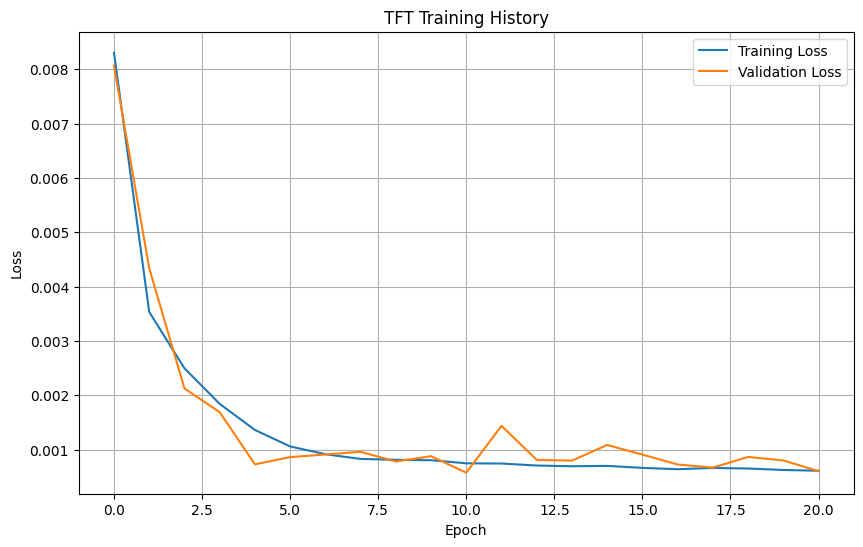


Training completed!


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=50, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0
        
        for batch_x, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            forecasts, feature_weights, attention_weights = model(batch_x)
            loss = criterion(forecasts, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        training_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                forecasts, feature_weights, attention_weights = model(batch_x)
                loss = criterion(forecasts, batch_y)
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        validation_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, 'best_tft_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return training_losses, validation_losses

# Prepare data for TFT model
def prepare_tft_data(sequences, targets, batch_size=64):
    # Convert to PyTorch tensors
    X = torch.FloatTensor(sequences)
    y = torch.FloatTensor(targets)
    
    # Create datasets
    train_dataset = TensorDataset(X, y)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

# Initialize model and training components
def initialize_training(num_features, hidden_size=64, learning_rate=1e-3):
    model = TemporalFusionTransformer(
        num_features=num_features,
        hidden_size=hidden_size,
        forecast_horizon=5
    )
    criterion = QuantileLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer

# Training pipeline
print("Preparing data...")
train_loader = prepare_tft_data(X_train, y_train, batch_size=64)
val_loader = prepare_tft_data(X_val, y_val, batch_size=64)

print("\nInitializing model...")
model, criterion, optimizer = initialize_training(num_features=X_train.shape[-1])

print("\nStarting training...")
training_losses, validation_losses = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=10
)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('TFT Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nTraining completed!")

Evaluating model on test set...


<ipython-input-9-31e03689bf65>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_tft_model.pth')



Test Loss: 0.000576

Plotting predictions...


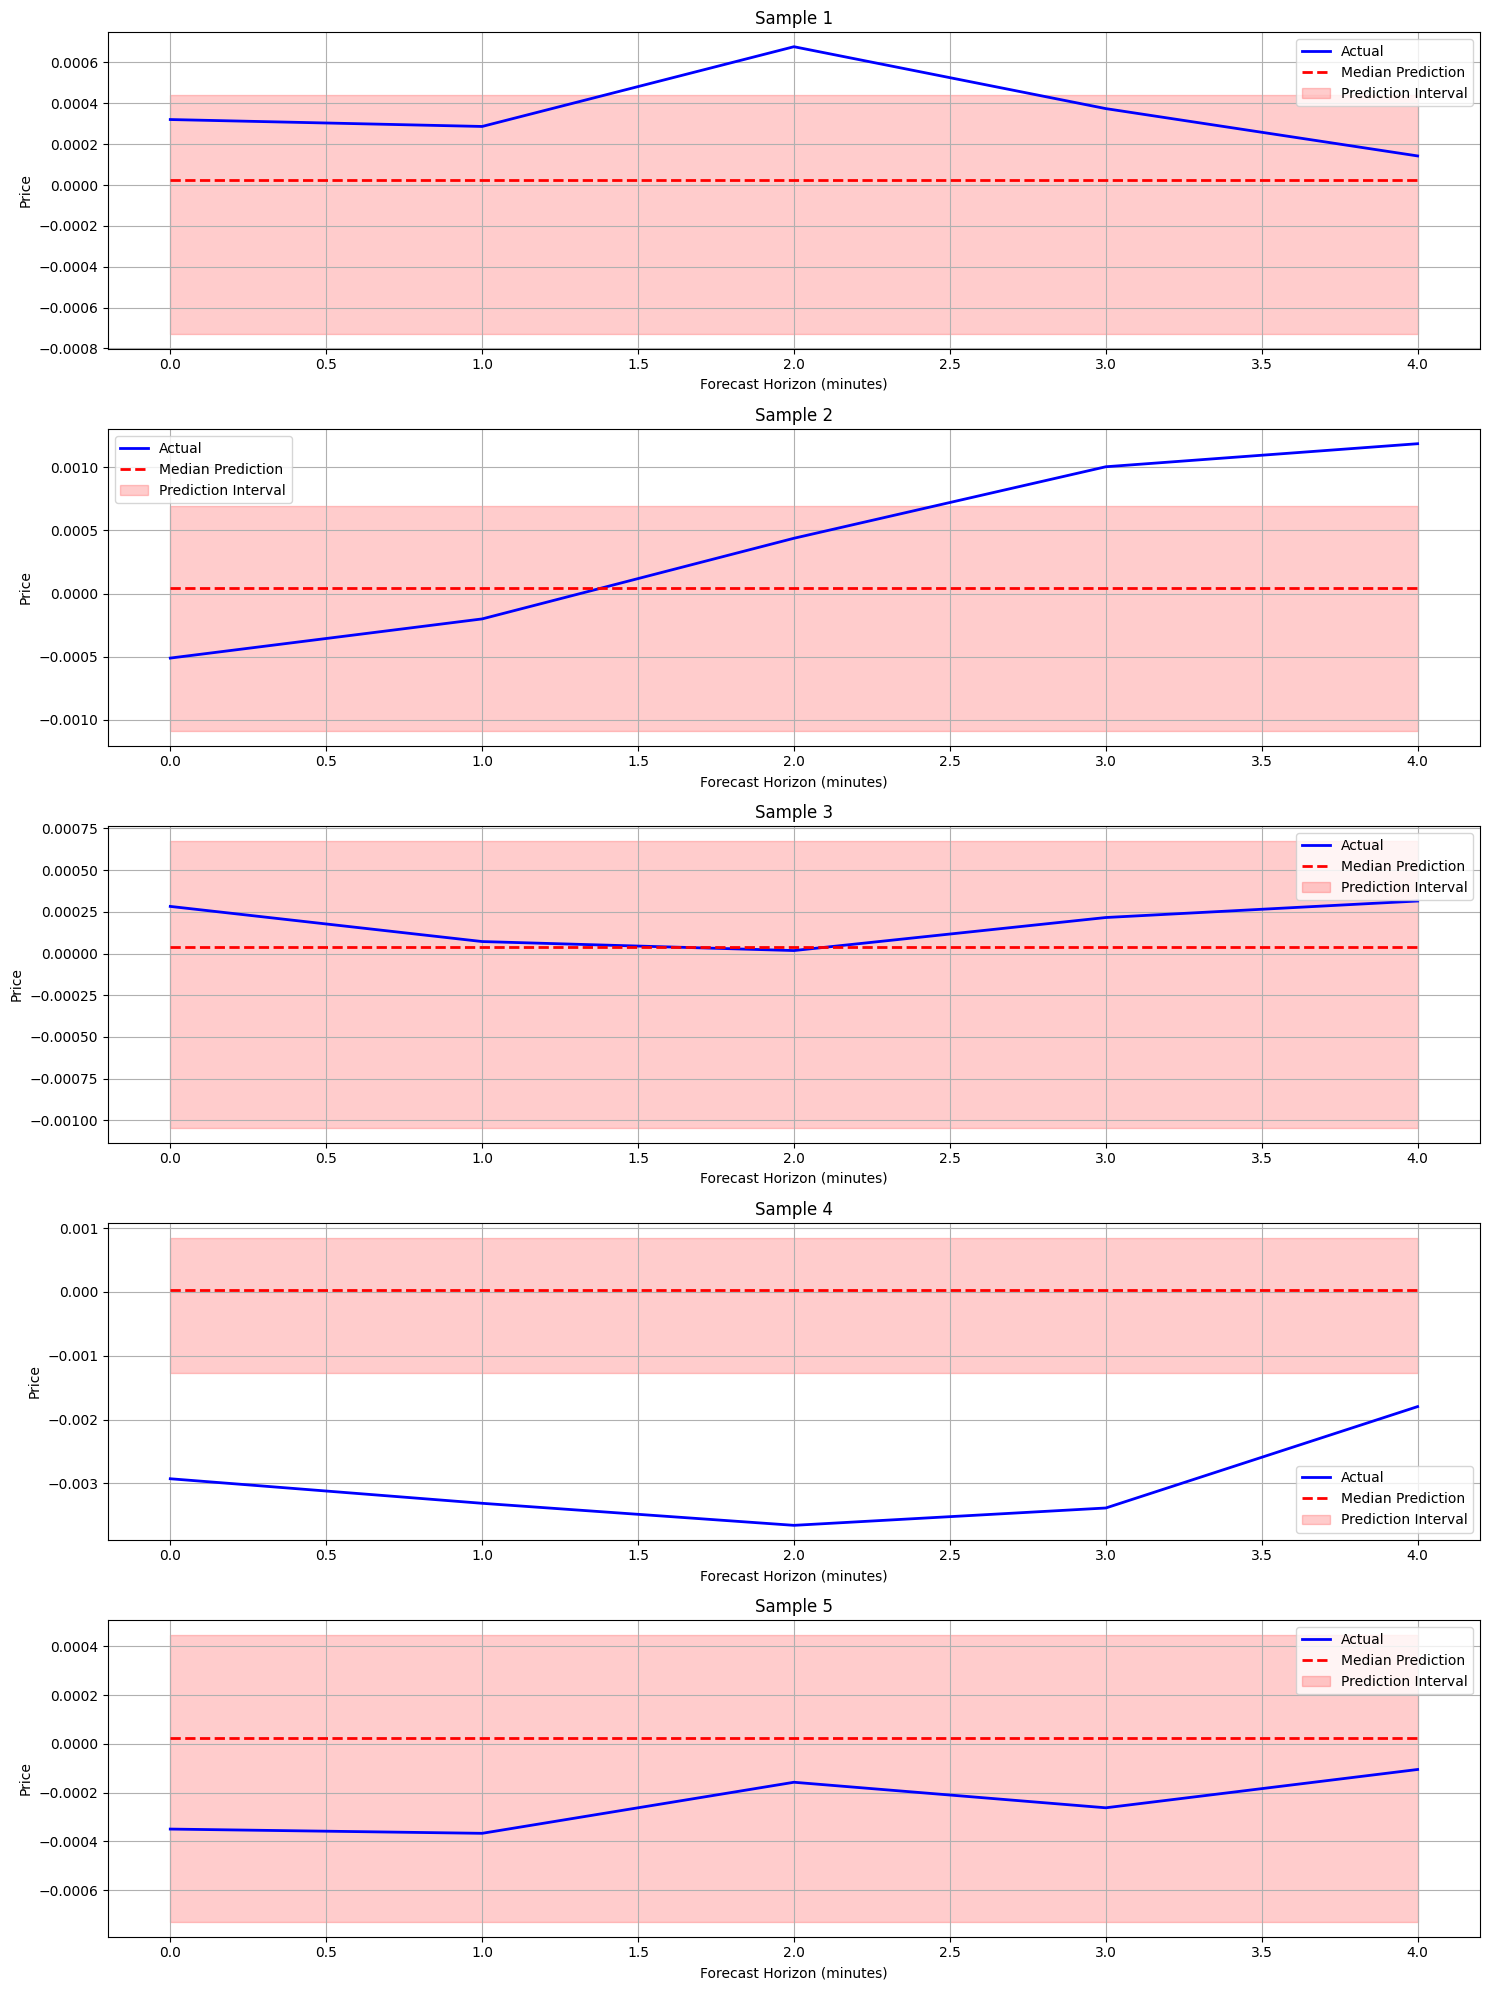


Plotting feature importance...


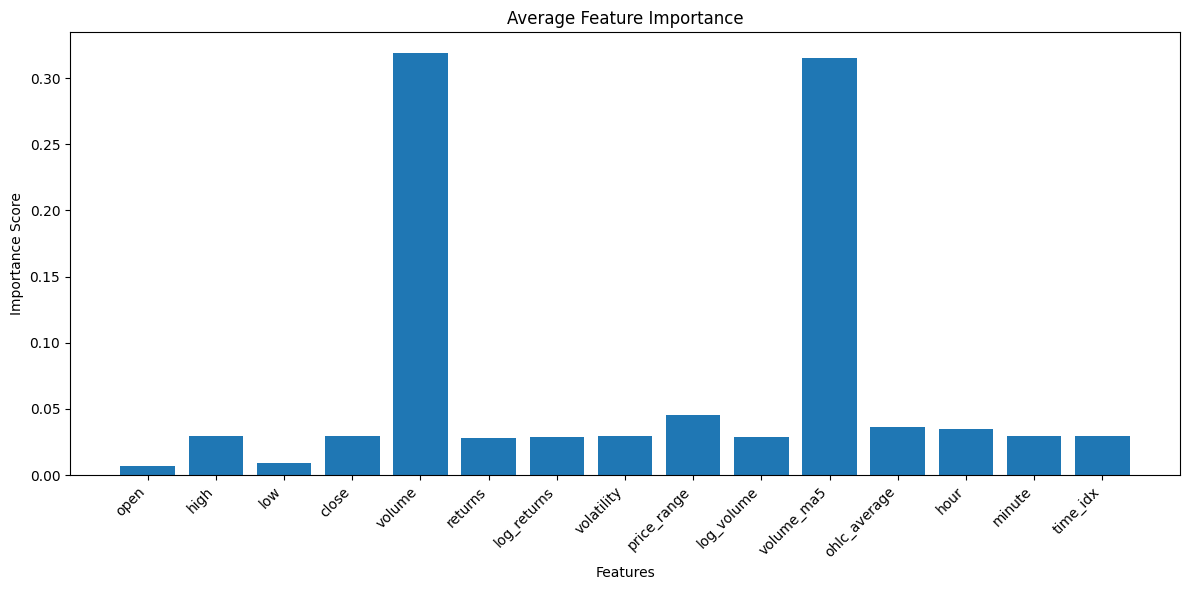


Plotting attention patterns...


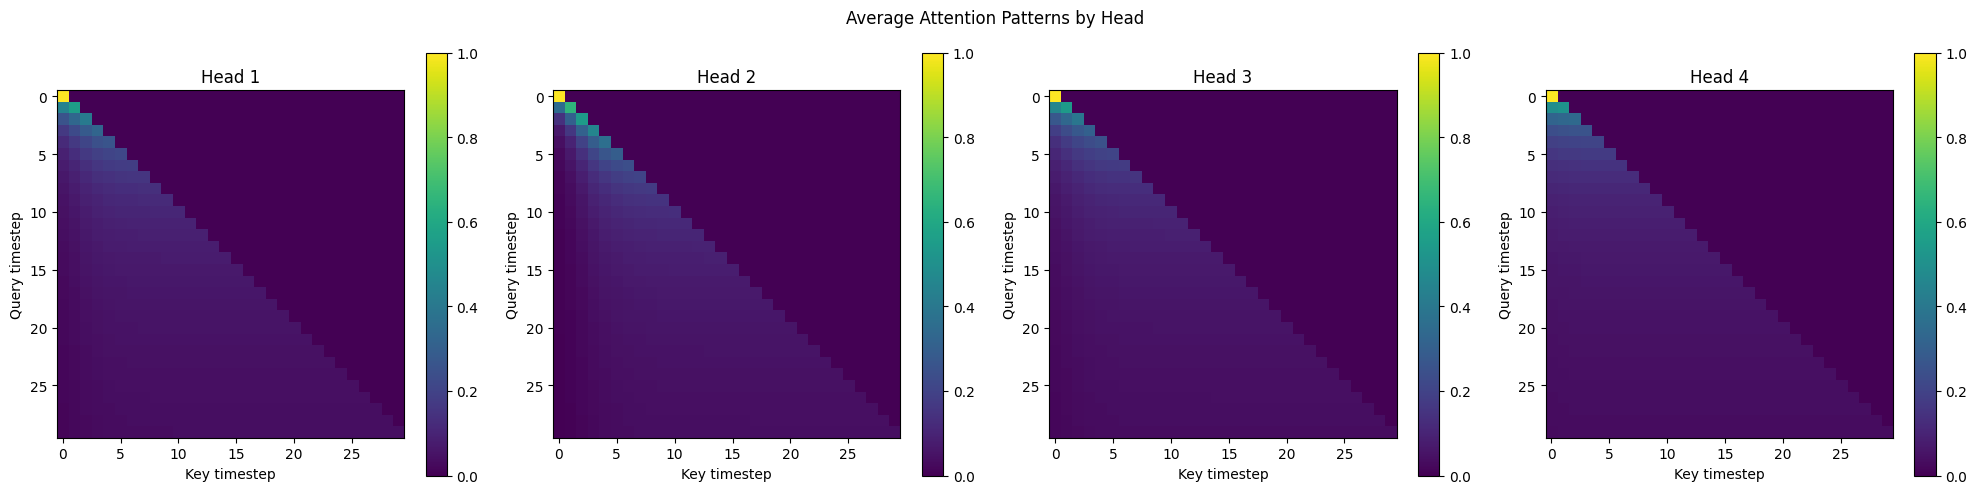

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    feature_weights_list = []
    attention_weights_list = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            forecasts, feature_weights, attention_weights = model(batch_x)
            loss = criterion(forecasts, batch_y)
            total_loss += loss.item()
            
            # Store predictions and actual values
            predictions.append(forecasts.cpu().numpy())
            actuals.append(batch_y.cpu().numpy())
            feature_weights_list.append(feature_weights.cpu().numpy())
            attention_weights_list.append(attention_weights.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    feature_weights = np.concatenate(feature_weights_list, axis=0)
    attention_weights = np.concatenate(attention_weights_list, axis=0)
    
    return predictions, actuals, feature_weights, attention_weights, total_loss / len(test_loader)

def plot_predictions(predictions, actuals, num_samples=5):
    """Plot predictions vs actuals for a few samples."""
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    horizons = np.arange(predictions.shape[1])
    
    for i in range(num_samples):
        ax = axes[i]
        # Plot actual values
        ax.plot(horizons, actuals[i], 'b-', label='Actual', linewidth=2)
        
        # Plot median prediction
        ax.plot(horizons, predictions[i, :, 1], 'r--', label='Median Prediction', linewidth=2)
        
        # Plot prediction intervals
        ax.fill_between(horizons, 
                       predictions[i, :, 0],  # Lower bound (10th percentile)
                       predictions[i, :, 2],  # Upper bound (90th percentile)
                       color='r', alpha=0.2, label='Prediction Interval')
        
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Forecast Horizon (minutes)')
        ax.set_ylabel('Price')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_weights, feature_names):
    """Plot average feature importance across all samples."""
    mean_importance = feature_weights.mean(axis=(0, 1))  # Average across samples and time
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(mean_importance)), mean_importance)
    plt.xticks(range(len(mean_importance)), feature_names, rotation=45, ha='right')
    plt.title('Average Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_attention_patterns(attention_weights, num_heads=4):
    """Plot attention patterns for each head."""
    fig, axes = plt.subplots(1, num_heads, figsize=(20, 5))
    
    for head in range(num_heads):
        avg_attention = attention_weights[:, head].mean(axis=0)  # Average across samples
        im = axes[head].imshow(avg_attention, cmap='viridis')
        axes[head].set_title(f'Head {head+1}')
        plt.colorbar(im, ax=axes[head])
        axes[head].set_xlabel('Key timestep')
        axes[head].set_ylabel('Query timestep')
    
    plt.suptitle('Average Attention Patterns by Head')
    plt.tight_layout()
    plt.show()

# Load the best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('best_tft_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# Create test dataloader
test_loader = prepare_tft_data(X_test, y_test, batch_size=64)

# Evaluate model
print("Evaluating model on test set...")
predictions, actuals, feature_weights, attention_weights, test_loss = evaluate_model(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.6f}")

# Plot results
print("\nPlotting predictions...")
plot_predictions(predictions, actuals)

print("\nPlotting feature importance...")
feature_names = ['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 
                'volatility', 'price_range', 'log_volume', 'volume_ma5', 'ohlc_average',
                'hour', 'minute', 'time_idx']
plot_feature_importance(feature_weights, feature_names)

print("\nPlotting attention patterns...")
plot_attention_patterns(attention_weights)

## Back Testing Setup

In [10]:
# 1. Import Dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from typing import List, Tuple, Dict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch

In [11]:
# 2. Data Preparation Functions
def prepare_backtest_features(df):
    """Prepare all necessary features for backtesting."""
    data = df.copy()
    
    # Basic price and volume features
    data['returns'] = data['close'].pct_change()
    data['log_returns'] = np.log(data['close']).diff()
    data['volatility'] = data['returns'].rolling(window=5).std()
    data['price_range'] = data['high'] - data['low']
    data['log_volume'] = np.log(data['volume'])
    data['volume_ma5'] = data['volume'].rolling(window=5).mean()
    data['ohlc_average'] = (data['open'] + data['high'] + data['low'] + data['close'])/4
    
    # Time-based features
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    
    # Add time index
    data['time_idx'] = range(len(data))
    
    # Fill missing values
    data = data.ffill().bfill()
    
    return data

In [12]:
# 3. Settings and Data Classes
@dataclass
class TradeSettings:
    commission: float = 0.0001
    slippage: float = 0.0001
    min_profit_threshold: float = 0.0008
    position_size: float = 10000.0
    max_positions: int = 1
    stop_loss: float = 0.0012
    take_profit: float = 0.0016
    
    # NEW: an extra threshold for "strong signals"
    strong_signal_threshold: float = 0.0020  # example: 20 bps

@dataclass
class Trade:
    entry_time: datetime
    entry_price: float
    position_size: float
    direction: int  # 1 for long, -1 for short
    exit_time: datetime = None
    exit_price: float = None
    pnl: float = None
    exit_reason: str = None

In [13]:
# 4. Model Wrapper Class
class ModelWrapper:
    def __init__(self, model, seq_mean, seq_std, target_mean, target_std, features):
        self.model = model
        # Convert tensors to numpy arrays for easier preprocessing
        self.seq_mean = seq_mean.cpu().numpy()
        self.seq_std = seq_std.cpu().numpy()
        self.target_mean = target_mean.item()
        self.target_std = target_std.item()
        self.features = features
        self.device = next(model.parameters()).device

    def normalize_sequence(self, sequence):
        """Normalize the input sequence using stored statistics."""
        sequence = np.array(sequence)
        mean = self.seq_mean.reshape(1, -1)
        std = self.seq_std.reshape(1, -1)
        return (sequence - mean) / (std + 1e-8)

    def denormalize_predictions(self, predictions):
        """Denormalize model predictions."""
        return predictions * (self.target_std + 1e-8) + self.target_mean

    def predict(self, sequence):
        """Generate predictions for a given sequence."""
        self.model.eval()
        with torch.no_grad():
            normalized_seq = self.normalize_sequence(sequence)
            normalized_seq = torch.FloatTensor(normalized_seq).unsqueeze(0).to(self.device)
            forecasts, _, _ = self.model(normalized_seq)
            forecasts = self.denormalize_predictions(forecasts)
            return forecasts.cpu().numpy()[0]

In [14]:
# 5. Trading Strategy Class (Updated)
# Updated Trading Strategy with enhanced risk management and filters
class TradingStrategy:
    def __init__(self, settings: TradeSettings):
        self.settings = settings
        self.active_trades: List[Trade] = []
        self.completed_trades: List[Trade] = []
        self.last_trade_time = None
        self.min_time_between_trades = pd.Timedelta(minutes=30)
        self.daily_pnl = {}
        self.max_daily_loss = -5000

    def check_exits(self, current_time, current_price):
        """Check if any active trades should be closed."""
        for trade in self.active_trades[:]:  # Copy list for iteration
            pnl_pct = (current_price - trade.entry_price) * trade.direction / trade.entry_price
            
            exit_reason = None
            if pnl_pct <= -self.settings.stop_loss:
                exit_reason = 'stop_loss'
            elif pnl_pct >= self.settings.take_profit:
                exit_reason = 'take_profit'
                
            if exit_reason:
                self.exit_trade(trade, current_time, current_price, exit_reason)
                
    def can_open_position(self):
        """Check if we can open a new position with enhanced risk checks."""
        if len(self.active_trades) >= self.settings.max_positions:
            return False
            
        # Check daily loss limit
        current_date = pd.Timestamp.now().date()
        if current_date in self.daily_pnl:
            if self.daily_pnl[current_date] < self.max_daily_loss:
                return False
                
        return True
            
    def generate_signal(self, predictions, current_price, current_time, volatility):
        """
        Generate trading signals based on stronger threshold logic and filters.
        """
        # Prevent back-to-back trades within a short time window
        if self.last_trade_time and (current_time - self.last_trade_time) < self.min_time_between_trades:
            return 0
    
        # Unpack quantiles: [lower, median, upper]
        lower_pred, median_pred, upper_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2]
    
        # Calculate expected return using the last forecasted minute
        expected_return = (median_pred[-1] - current_price) / current_price
        prediction_spread = (upper_pred[-1] - lower_pred[-1]) / current_price
    
        # Optional filters:
        #  - Spread check
        #  - Volatility check
        #  - Minimum expected return check
        if any([
            prediction_spread > 0.001,  # You can fine-tune or remove this
            volatility > np.percentile(volatility, 70),  # Adjust volatility filter
            abs(expected_return) < self.settings.min_profit_threshold
        ]):
            return 0
    
        # Strong signal threshold logic
        if expected_return > self.settings.strong_signal_threshold:
            # Require an upward trend for all horizons
            if all(pred > current_price for pred in median_pred):
                return 1
        elif expected_return < -self.settings.strong_signal_threshold:
            # Require a downward trend for all horizons
            if all(pred < current_price for pred in median_pred):
                return -1
    
        # No trade signal if conditions are not met
        return 0


    def enter_trade(self, current_time, current_price, direction):
        """Enter trade with position sizing based on volatility."""
        self.last_trade_time = current_time
        
        # Calculate position size based on available capital
        position_size = min(
            self.settings.position_size,
            abs(self.max_daily_loss * 2)  # Limit position size based on max loss
        )
        
        trade = Trade(
            entry_time=current_time,
            entry_price=current_price,
            position_size=position_size,
            direction=direction
        )
        self.active_trades.append(trade)
        return trade

    def exit_trade(self, trade, current_time, current_price, reason):
        """Exit trade with enhanced PnL tracking."""
        trade.exit_time = current_time
        trade.exit_price = current_price
        trade.exit_reason = reason
        
        # Calculate PnL
        price_change = (trade.exit_price - trade.entry_price) * trade.direction
        trade.pnl = (price_change - (self.settings.commission + self.settings.slippage) * 2) * trade.position_size
        
        # Update daily PnL tracking
        trade_date = trade.exit_time.date()
        if trade_date not in self.daily_pnl:
            self.daily_pnl[trade_date] = 0
        self.daily_pnl[trade_date] += trade.pnl
        
        self.active_trades.remove(trade)
        self.completed_trades.append(trade)
        return trade



In [15]:
# 6. Backtest Engine Class
class BacktestEngine:
    def __init__(self, data, model_wrapper, strategy, lookback_window):
        self.data = data
        self.model_wrapper = model_wrapper
        self.strategy = strategy
        self.lookback_window = lookback_window

    def prepare_sequence(self, current_idx):
        """Prepare sequence for model input."""
        sequence = self.data.iloc[current_idx-self.lookback_window:current_idx][self.model_wrapper.features].values
        return sequence

    def run(self):
        """Run the backtest."""
        print("Running backtest...")
        
        for i in tqdm(range(self.lookback_window, len(self.data))):
            current_time = self.data.index[i]
            current_price = self.data.iloc[i]['close']
            current_volatility = self.data.iloc[i]['volatility']
            
            self.strategy.check_exits(current_time, current_price)
            
            if self.strategy.can_open_position():
                sequence = self.prepare_sequence(i)
                predictions = self.model_wrapper.predict(sequence)
                signal = self.strategy.generate_signal(predictions, current_price, current_time, current_volatility)
                
                if signal != 0:
                    self.strategy.enter_trade(current_time, current_price, signal)
        
        # Close remaining trades
        for trade in self.strategy.active_trades[:]:
            self.strategy.exit_trade(
                trade,
                self.data.index[-1],
                self.data.iloc[-1]['close'],
                'end_of_period'
            )
        
        return self.calculate_metrics()

    def calculate_metrics(self):
        """Calculate backtest performance metrics."""
        trades = self.strategy.completed_trades
        if not trades:
            return None

        metrics = {
            'total_trades': len(trades),
            'winning_trades': len([t for t in trades if t.pnl > 0]),
            'total_pnl': sum(t.pnl for t in trades),
            'avg_trade_pnl': np.mean([t.pnl for t in trades]),
            'sharpe_ratio': self.calculate_sharpe_ratio(trades),
            'max_drawdown': self.calculate_max_drawdown(trades),
        }
        metrics['win_rate'] = metrics['winning_trades'] / metrics['total_trades']
        
        return metrics

    @staticmethod
    def calculate_sharpe_ratio(trades, risk_free_rate=0.02):
        if not trades:
            return 0
        returns = np.array([t.pnl for t in trades])
        excess_returns = returns - risk_free_rate/252
        if len(excess_returns) < 2:
            return 0
        return np.mean(excess_returns) / (np.std(excess_returns) + 1e-8) * np.sqrt(252)

    @staticmethod
    def calculate_max_drawdown(trades):
        if not trades:
            return 0
        cumulative = np.cumsum([t.pnl for t in trades])
        max_dd = 0
        peak = cumulative[0]
        
        for value in cumulative[1:]:
            if value > peak:
                peak = value
            dd = (peak - value) / (peak + 1e-8)
            max_dd = max(max_dd, dd)
        
        return max_dd

In [16]:
# 7. Run Backtest
# Define features
OBSERVED_FEATURES = [
    'open', 'high', 'low', 'close', 'volume',
    'returns', 'log_returns', 'volatility', 'price_range',
    'log_volume', 'volume_ma5', 'ohlc_average',
    'hour', 'minute', 'time_idx'
]

# Prepare data
print("Preparing backtest data...")
df_backtest = prepare_backtest_features(df)

# Initialize components
model_wrapper = ModelWrapper(
    model=model,
    seq_mean=train_dataset.seq_mean,
    seq_std=train_dataset.seq_std,
    target_mean=train_dataset.target_mean,
    target_std=train_dataset.target_std,
    features=OBSERVED_FEATURES
)

settings = TradeSettings()
strategy = TradingStrategy(settings)

# Run backtest
backtest = BacktestEngine(
    data=df_backtest,
    model_wrapper=model_wrapper,
    strategy=strategy,
    lookback_window=30
)

# Execute backtest
metrics = backtest.run()

Preparing backtest data...
Running backtest...


100%|██████████| 47739/47739 [01:34<00:00, 504.47it/s] 


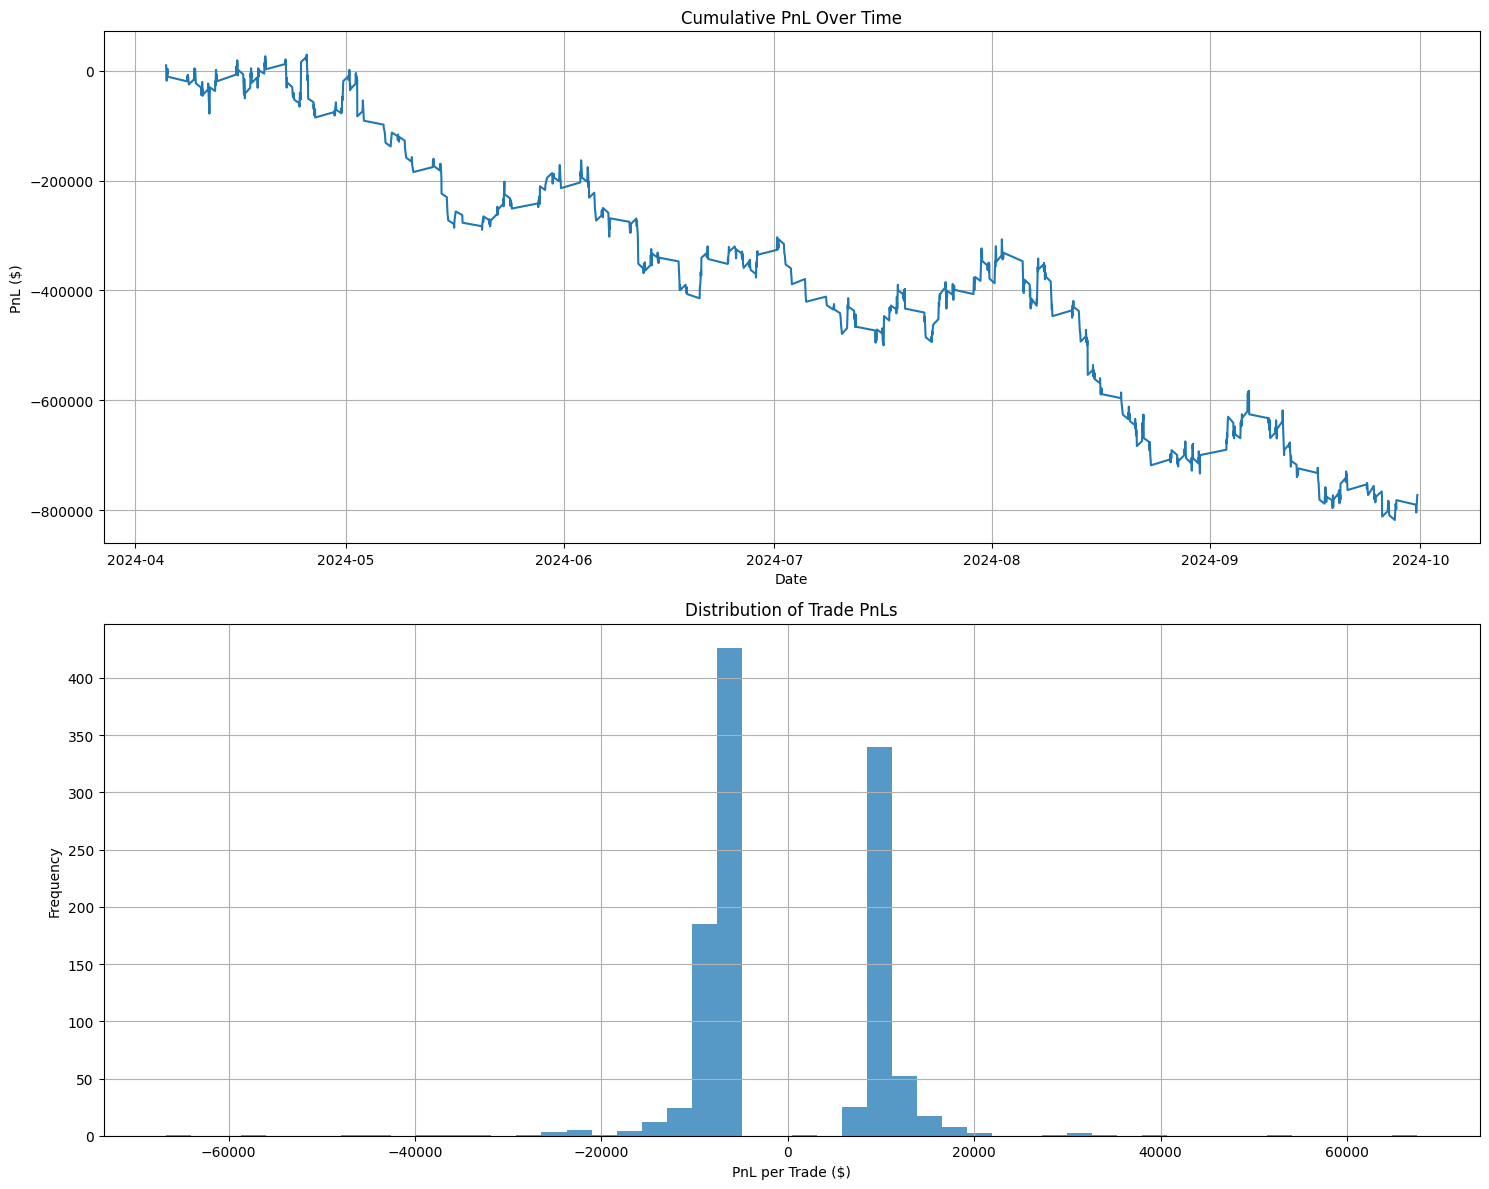


Detailed Backtest Results:
Total Trades: 1120
Win Rate: 40.36%
Total PnL: $-772,490.00
Average Trade PnL: $-689.72
Sharpe Ratio: -1.046
Max Drawdown: 2851.94%


In [17]:
# 8. Analyze and Plot Results
def plot_backtest_results(trades, metrics):
    """Plot backtest results with detailed analytics."""
    if not trades:
        print("No trades were executed during the backtest period.")
        return
        
    # Calculate cumulative PnL
    cumulative_pnl = np.cumsum([t.pnl for t in trades])
    trade_times = [t.entry_time for t in trades]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot cumulative PnL
    ax1.plot(trade_times, cumulative_pnl, label='Cumulative PnL')
    ax1.set_title('Cumulative PnL Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('PnL ($)')
    ax1.grid(True)
    
    # Plot trade distribution
    pnls = [t.pnl for t in trades]
    ax2.hist(pnls, bins=50, alpha=0.75)
    ax2.set_title('Distribution of Trade PnLs')
    ax2.set_xlabel('PnL per Trade ($)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Backtest Results:")
    print(f"Total Trades: {metrics['total_trades']}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Total PnL: ${metrics['total_pnl']:,.2f}")
    print(f"Average Trade PnL: ${metrics['avg_trade_pnl']:,.2f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")

# Plot results
plot_backtest_results(backtest.strategy.completed_trades, metrics)